In [1]:
from gpcam import GPOptimizer

import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt

import os
import csv

import random

In [2]:
def my_noise(x,hps):

    my_slope     = hps[0]
    my_pow       = hps[1]
    my_intercept = hps[2]

    my_s = my_slope * x**my_pow + my_intercept

    noise = np.diag(my_s[:,0])
    
    return noise


# Mean function: Two-Element piecewise function
def mean2(x,hps):

    x0 = hps[3]
    
    m1 = hps[4]
    m2 = hps[5] + m1

    b1  = 500
    b2 = (m1 - m2) * x0 + b1

    y = np.where(x <= x0, m1*x + b1, m2*x + b2)
                
    return y

# Generating the Synthetic Data

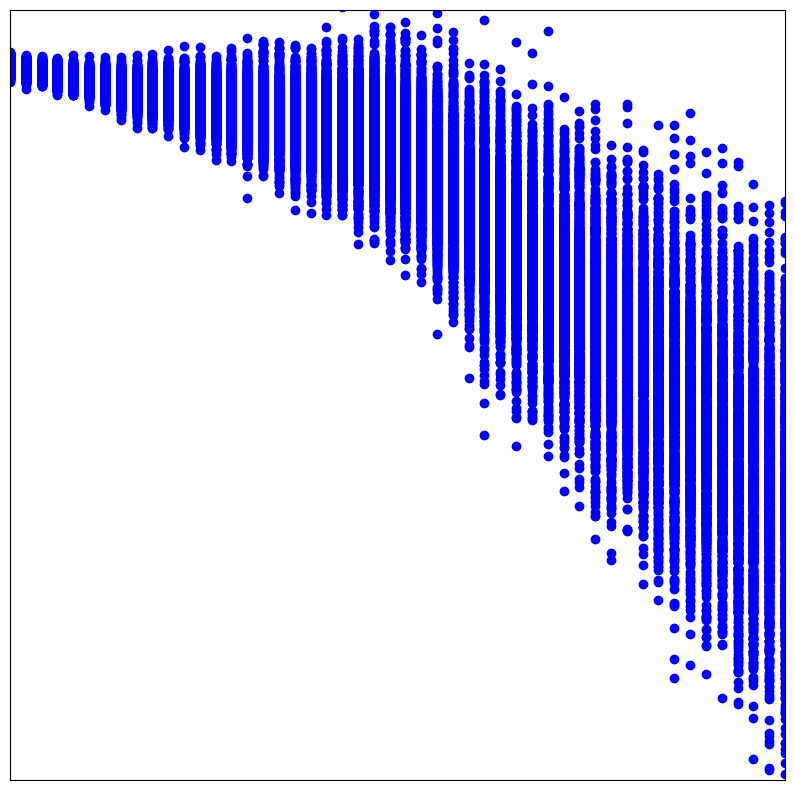

In [3]:

x = np.linspace(0,1000,50).reshape(-1,1)

hps = np.array([1.002e-05,  2.69, 3,      # Noise
                500,-0.05,-0.2])  # Mean

# We only use the noise model to get the covariance because we are looking at the likelihood. 
# So no need for the kernel function to be defined to add it to the covariance matrix of the Multivariate Gaussian. 

# Calculate the Noise Model
noise_model = my_noise(x,hps)

# Calculate the Mean Model
mean_model = mean2(x,hps)[:,0]

# Number of realizations to generate
num_batteries = int(1e4) # You can adjust this value
num_batteries = int(1000) # You can adjust this value

#realization = np.random.multivariate_normal(mean_model, noise_model,num_batteries)    

realization = np.load("C:\\Users\\Maher Alghalayini\\Desktop\\Paper 1 Material\\Synthetic Data Generation_New\\my_synthetic_energy.npy")


label_size = 30


plt.figure(figsize = (10,10))
# Generate and plot the realizations
for i in range(num_batteries):
    plt.scatter(x, realization[i,:],color='blue')
# Customize the plot
plt.tick_params(axis='both', which='major', labelsize=label_size)
#plt.xlabel("Cycle Number", fontsize=label_size)
#plt.ylabel("Quantity of Interest", fontsize=label_size)
#plt.grid(True)
plt.xlim(0,1000)
plt.xticks([])

plt.ylim([250,520])
plt.yticks([])
#plt.show()
#plt.savefig('All_Synthetic_Data2.png') # saving plot with a unique name 
plt.savefig('All_Synthetic_Data2.pdf', bbox_inches='tight')

#plt.close() # closing the plot to free up memory
    
#np.save('my_synthetic_energy.npy', realization)
#np.save('my_synthetic_cycleNum.npy',x)

In [9]:
realization.shape

(10000, 50)

# Calculating the variance

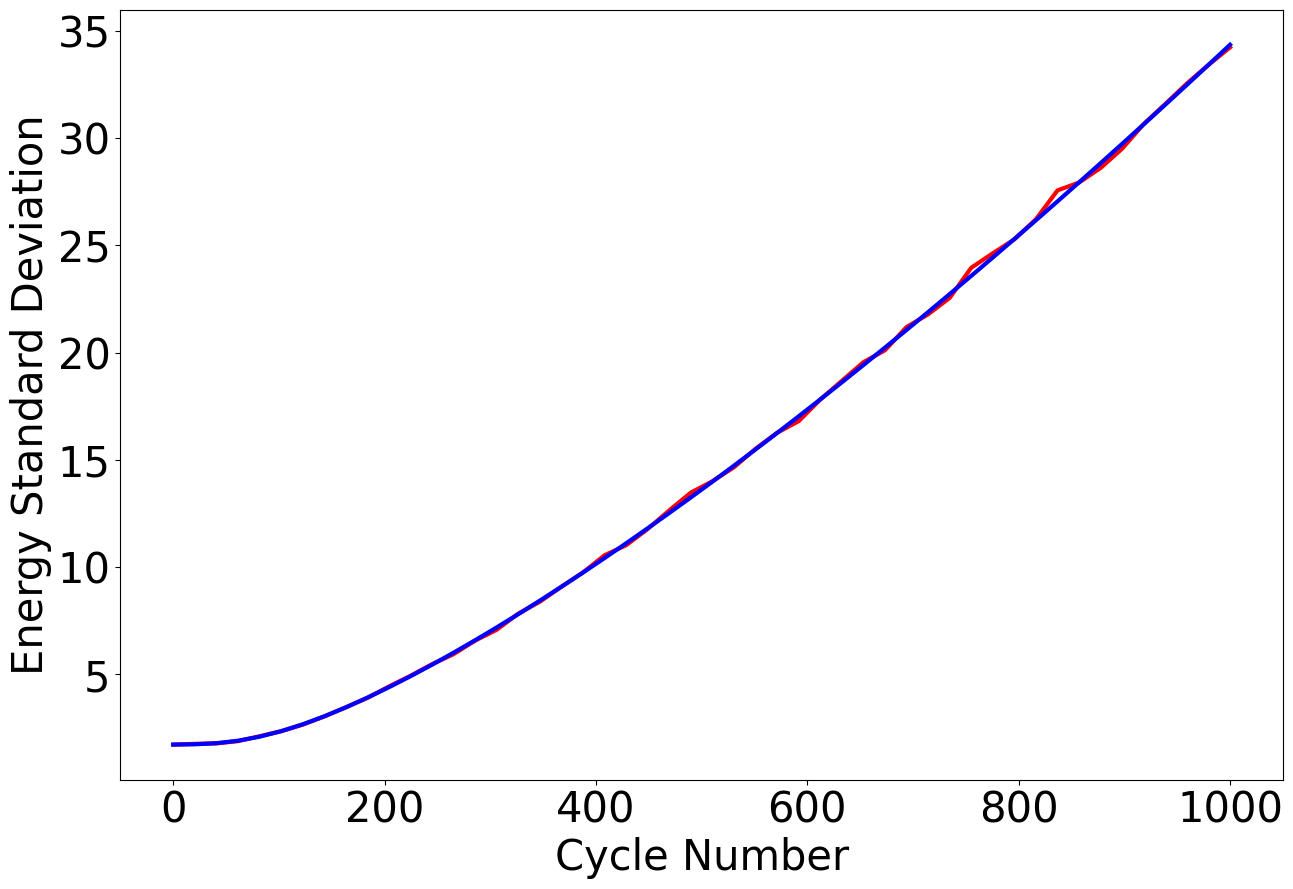

In [10]:
# Checking the variability trend in the data

variances = np.var(realization, axis=0)
stds = np.sqrt(variances)

#print(variances)

# Plotting the data
plt.figure(figsize = (15,10))
plt.plot(x,stds, color = "red", linewidth = 3)
plt.plot(x,np.sqrt(np.diag(noise_model)), color="blue", linewidth = 3)
plt.xlabel("Cycle Number",fontsize=label_size)
plt.ylabel("Energy Standard Deviation",fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes
plt.show()

# Creating battery Trends to Follow Experimental Data 

In [11]:
def get_distance_matrix(x1,x2):
    d = np.zeros((len(x1),len(x2)))
    for i in range(x1.shape[1]):
        d += (x1[:,i].reshape(-1, 1) - x2[:,i])**2
    return np.sqrt(d)


def my_noise(x,hps,obj):

    my_slope     = hps[2]
    my_pow       = hps[3]
    my_intercept = hps[4]

    my_s = my_slope * x**my_pow + my_intercept
    noise = np.diag(my_s[:,0])

    return noise


def kernel(x1,x2,hps,obj):
    d = get_distance_matrix(x1,x2) 

    k = hps[0] * obj.squared_exponential_kernel(d,hps[1]) 
    return k

# here I am assuming that the mean function is a piecewise function
def mean2(x,hps,obj):

    x0 = hps[5]

    m1 = hps[6]
    m2 = hps[7]
    
    b1 = 500
    b2 = (m1 - m2) * x0 + b1

    y = np.where(x[:,0] <= x0, m1*x[:,0] + b1, m2*x[:,0] + b2)
    return y

In [23]:
considered_batteries = np.array([5546, 9477, 2231, 4437, 7059, 5259, 8330, 1068, 8214, 5888, 3275, 6845, 7671, 
                         299, 5038, 3503, 8673, 2236, 3644, 4980, 993, 7545, 654, 1418, 6090, 7936, 8792, 
                         6910, 2933, 2382, 9730, 8476, 1882, 7986, 7091, 4813, 3086, 3908, 1539, 8567, 2152, 
                         5738, 8646, 9692, 2661, 6766, 7230, 512, 758, 2881])

init_hyperparameters = np.array([150, 250,                # Kernel
                                  0.06, 2, 2,             # Noise  
                                  250,-0.01,-0.015])      # Mean.


# Setting the Optimization Bounds for Hyperparameters
bounds = np.empty((8,2))
# Kernel Sq Exp 
bounds[0] = np.array([100.,10000.])                         # Kernel Variance
bounds[1] = np.array([10.,400.])                           # Kernel Lengthscale
# Noise
bounds[2] = np.array([1e-5,1.])                            # Noise Slope
bounds[3] = np.array([1.,5.])                              # Noise Power
bounds[4] = np.array([0.,3.])                              # Noise Intercept
# Mean
bounds[5] = np.array([200.,700.])                          # Mean Piecewise Intersection point
bounds[6] = np.array([-1e-1,-1e-3])                        # Mean Slope 1
bounds[7] = np.array([-5e-1,-1e-3])                        # Mean Slope 2

x_data = np.empty((0, 1))
y_data = np.empty((0, 1))

for battery in considered_batteries: # The number of batteries loop!
    
    current_energy = realization[battery]
    
    my_gp1 = GPOptimizer(x,current_energy,
            init_hyperparameters = init_hyperparameters,  # we need enough of those for kernel, noise and prior mean functions
            #noise_variances=np.ones(y_data.shape) * 0.01, #provding noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            gp_kernel_function=kernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=mean2, 
            gp_mean_function_grad=None,
            gp_noise_function=my_noise,
            normalize_y=False,
            sparse_mode=False,
            gp2Scale = False,
            store_inv=False, 
            ram_economy=False, 
            args=None)

 
    my_gp1.train(bounds, method='global')
    
    f = my_gp1.posterior_mean(x)["f(x)"]
    v =  my_gp1.posterior_covariance(x, variance_only=False, add_noise=True)["v(x)"]
    
    '''
    # Plotting the data
    plt.figure(figsize = (10,10))
    plt.plot(x[:,0],f, color = "blue", linewidth = 3,label='Fitted Model')
    plt.scatter(x,current_energy, color = "black",label='Data Points') # Training Data
    plt.fill_between(x[:,0],f - 2. * np.sqrt(v), f + 2. * np.sqrt(v), alpha = 0.5, color = "grey", label='Confidence Interval')
    plt.xlabel("Cycle Number",fontsize=label_size) 
    plt.ylabel("Energy",fontsize=label_size)
    plt.ylim(380,510)
    #plt.yticks([130, 180, 230, 280, 330, 380])
    plt.xlim(0,1000)
    plt.legend(fontsize=label_size,frameon=False,loc='lower left')
    plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes
    '''

    x_data = np.append(x_data,x)
    y_data = np.append(y_data,f)

    print("A battery is done")
    

np.save('my_synthetic_x_batteryTrend.npy', x_data)
np.save('my_synthetic_y_batteryTrend.npy', y_data)



A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done
A battery is done


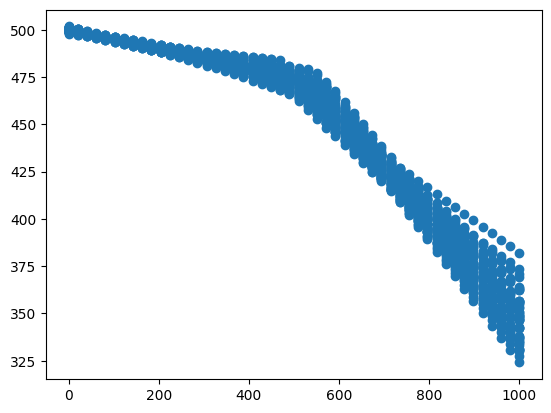

In [24]:
plt.scatter(x_data,y_data)